# AMR-T5-Model Evaluation


In [1]:
# Installing required packages
!pip install datasets transformers sentencepiece accelerate -U tensorflow --upgrade torch torchvision peft nltk rouge_score arabert evaluate bert-score > /dev/null 2>&1

In [2]:
# Loading packages
import random
from rouge_score import rouge_scorer
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from peft import LoraConfig, TaskType, get_peft_model, PeftModel
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    default_data_collator,
    MT5Tokenizer,
)
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
from google.colab import drive
from bert_score import score

In [ ]:
test="/content/articles.csv"
# Path to all the models and datasets
folder_path = '/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/mT5-PEFT-Amharic-Text-Summarization-main/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# 1. Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load the merged model and tokenizer from the Hugging Face Hub
model = AutoModelForSeq2SeqLM.from_pretrained("Desalegnn/amharic-t5-LoRA-f")
tokenizer = AutoTokenizer.from_pretrained("Desalegnn/amharic-t5-LoRA-f")

# 3. Move the model to the correct device
model.to(device)

# 4. Set the model to evaluation mode (disables dropout, etc.)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [ ]:
test="/content/drive/MyDrive/articles.csv"
# Loading processed data, which includes the preprocessed and tokenized versions of the text and summary entries
tokenized_datasets = DatasetDict.load_from_disk('/content/drive/MyDrive/mT5-PEFT-Amharic-Text-Summarization-main/brand_new_further_cleaned_Amharic_mT5_tokenized_datasets') # This specific file is the preprocessed and tokenized version of Amharic-2

In [ ]:
import torch 
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, default_data_collator
from tqdm import tqdm
import torch.nn.functional as F

# ✅ AMRModel Class with Salience + Novelty + Combined Score
class AMRModel:
    def __init__(self, context_window_size, model_name, alpha=0.7, beta=0.3):
        self.context_window_size = context_window_size
        self.memory_bank = []
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device).eval()
        self.alpha = alpha  # salience weight
        self.beta = beta    # novelty weight

    def tokenize_and_chunk(self, input_text):
        input_ids = self.tokenizer.encode(input_text, return_tensors="pt", truncation=False)[0]
        chunks = [input_ids[i:i + self.context_window_size] for i in range(0, len(input_ids), self.context_window_size)]
        return chunks, input_ids

    def encode_chunk(self, chunk_tensor):
        with torch.no_grad():
            encoder_output = self.model.encoder(input_ids=chunk_tensor)
        return encoder_output.last_hidden_state

    def compute_salience(self, hidden_states):
        return torch.norm(hidden_states, dim=-1).squeeze(0)

    def compute_novelty(self, token_reps, selected_reps):
        novelty_scores = []
        for h_i in token_reps:
            max_sim = max([F.cosine_similarity(h_i, h_j, dim=0) for h_j in selected_reps], default=torch.tensor(-1.0))
            novelty = 1 - max_sim.item()
            novelty_scores.append(novelty)
        return torch.tensor(novelty_scores)

    def select_top_k_tokens_from_text(self, input_text):
        chunks, _ = self.tokenize_and_chunk(input_text)
        memory_bank = []
        global_token_position = 0
        selected_reps = []

        for i, chunk in enumerate(chunks):
            chunk_tensor = chunk.unsqueeze(0).to(self.device)
            hidden_states = self.encode_chunk(chunk_tensor).squeeze(0)
            salience_scores = self.compute_salience(hidden_states)

            if i == 0:
                novelty_scores = torch.zeros_like(salience_scores)
            else:
                novelty_scores = self.compute_novelty(hidden_states, selected_reps)

            combined_scores = self.alpha * salience_scores + self.beta * novelty_scores

            for j, token_id in enumerate(chunk.tolist()):
                memory_bank.append({
                    "token": token_id,
                    "score": combined_scores[j].item(),
                    "position": global_token_position,
                    "rep": hidden_states[j].detach().cpu()
                })
                global_token_position += 1

            selected_reps.extend(hidden_states.detach().cpu())

        top_k = sorted(memory_bank, key=lambda x: x["score"], reverse=True)[:self.context_window_size]
        top_k_sorted = sorted(top_k, key=lambda x: x["position"])
        top_k_token_ids = [entry["token"] for entry in top_k_sorted]
        return torch.tensor([top_k_token_ids], dtype=torch.long).to(self.device)

    def expand_context_with_amr(self, input_ids_batch):
        expanded_batch = []
        for input_ids in input_ids_batch:
            text = self.tokenizer.decode(input_ids, skip_special_tokens=True)
            top_k_input = self.select_top_k_tokens_from_text(text)

            current_len = top_k_input.shape[1]
            if current_len < self.context_window_size:
                pad_len = self.context_window_size - current_len
                pad_tensor = torch.full((1, pad_len), self.tokenizer.pad_token_id, dtype=torch.long).to(self.device)
                top_k_input = torch.cat([top_k_input, pad_tensor], dim=1)
            elif current_len > self.context_window_size:
                top_k_input = top_k_input[:, :self.context_window_size]

            expanded_batch.append(top_k_input)

        return torch.cat(expanded_batch, dim=0)

    def generate_final_output(self, input_text, max_tokens=192):
        encoded = self.tokenizer(input_text, return_tensors="pt", truncation=False)
        input_ids = encoded["input_ids"].to(self.device)
        token_count = input_ids.shape[1]

        if token_count <= self.context_window_size:
            with torch.no_grad():
                output_ids = self.model.generate(
                    input_ids=input_ids,
                    max_new_tokens=max_tokens,
                    num_beams=4,
                    early_stopping=True
                )
        else:
            top_k_ids = self.select_top_k_tokens_from_text(input_text)
            with torch.no_grad():
                encoder_outputs = self.model.encoder(input_ids=top_k_ids)
                output_ids = self.model.generate(
                    input_ids=top_k_ids,
                    encoder_outputs=encoder_outputs,
                    max_new_tokens=max_tokens,
                    num_beams=4,
                    early_stopping=True
                )

        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True)

# ✅ Initialize AMR model
model_name = "Desalegnn/amharic-t5-LoRA-f"
amr_model = AMRModel(context_window_size=512, model_name=model_name)
tokenizer = amr_model.tokenizer
model = amr_model.model
device = amr_model.device

# ✅ Load tokenized test dataset (preprocessed separately)
test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=default_data_collator,
    batch_size=64,
    pin_memory=True
)

# ✅ Generate summaries using AMR
summaries = []
for step, batch in enumerate(tqdm(test_dataloader, desc="AMR Batch Inference")):
    batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
    input_ids = batch["input_ids"]

    with torch.no_grad():
        expanded_input_ids = amr_model.expand_context_with_amr(input_ids)
        outputs = model.generate(
            input_ids=expanded_input_ids,
            max_new_tokens=192,
            num_beams=4,
            early_stopping=True
        )

    decoded = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)
    summaries.extend(decoded)


AMR Batch Inference: 100%|██████████| 32/32 [11:48<00:00, 22.15s/it]


## Quantitative Evaluations

### ROUGE Scores

In [49]:
# Getting the reference summaries to compare the generated summaries with
references = [tokenized_datasets["test"][i]["summary"] for i in range(len(summaries))]

ROUGE-2: 0.03998779692182991
ROUGE-L: 0.11840338009091929


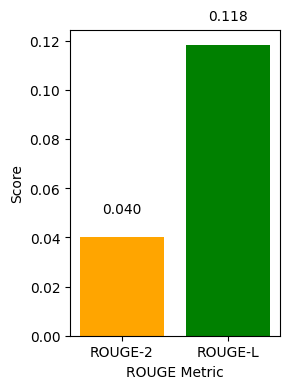

In [52]:
# Initializing Rouge scorer
scorer = rouge_scorer.RougeScorer(["rouge2", "rougeLsum"], use_stemmer=True)

# Calculating ROUGE scores
import matplotlib.pyplot as plt

# Calculate ROUGE Scores
rouge_scores = [
    scorer.score(summary, reference) for summary, reference in zip(summaries, references)
]

rouge2 = sum([score["rouge2"].fmeasure for score in rouge_scores]) / len(rouge_scores)  # Average ROUGE-2
rougeLsum = sum([score["rougeLsum"].fmeasure for score in rouge_scores]) / len(rouge_scores)  # Average ROUGE-L

# Print the Average ROUGE Scores
print(f"ROUGE-2: {rouge2}")
print(f"ROUGE-L: {rougeLsum}")

# Step to create the bar graph
# Data for the bar graph
rouge_labels = ['ROUGE-2', 'ROUGE-L']
rouge_values = [rouge2, rougeLsum]

# Creating the bar graph
plt.figure(figsize=(3, 4))
plt.bar(rouge_labels, rouge_values, color=['orange', 'green'])

# Adding the title and labels
plt.ylabel('Score')
plt.xlabel('ROUGE Metric')

# Display the value of each bar at the top
for i, value in enumerate(rouge_values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center')

# Show the graph
plt.tight_layout()
plt.show()


### BLEU Score

In [53]:
# Prepare the reference and candidate sentences for BLEU
list_of_references = [[ref.split()] for ref in references]  # BLEU expects a list of lists of tokens
candidates = [summary.split() for summary in summaries]

# Compute the BLEU-4 score using the NLTK function
bleu_score = corpus_bleu(list_of_references, candidates,
                         smoothing_function=SmoothingFunction().method1)

print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.5022601455310922


### BERTScores (Precision, Recall and F1)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Precision: 0.8158698678016663
 Recall: 0.7749159932136536
F1: 0.791543185710907


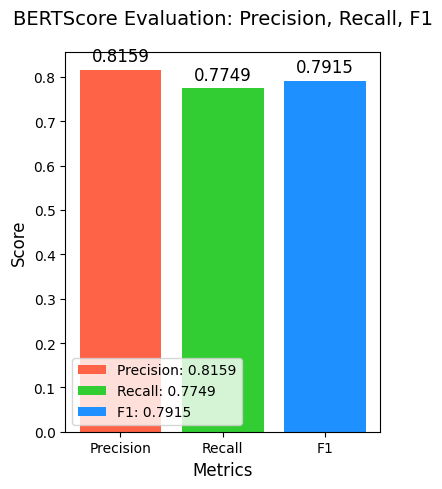

In [ ]:
import matplotlib.pyplot as plt
from bert_score import score

# Assuming `summaries` contains your generated summaries and `references` contains the reference summaries
P, R, F1 = score(summaries, references, model_type="Desalegnn/amharic-t5-LoRA-f")

# Calculate average Precision, Recall, and F1
avg_precision = sum(P) / len(P)
avg_recall = sum(R) / len(R)
avg_f1 = sum(F1) / len(F1)
# Print the Average ROUGE Scores
print(f"Precision: {avg_precision}")
print(f" Recall: {avg_recall}")
print(f"F1: {avg_f1}")

# Create a smart bar graph for BERTScore (Precision, Recall, F1)
labels = ['Precision', 'Recall', 'F1']
averages = [avg_precision, avg_recall, avg_f1]
all_scores = [P, R, F1]

# Define colors for each bar (chosen to be more aesthetic)
colors = ['#FF6347', '#32CD32', '#1E90FF']  # Tomato, LimeGreen, DodgerBlue

# Create a bar chart
plt.figure(figsize=(4, 5))

# Plot the bar graph for each metric (Precision, Recall, F1) and their averages
bars = []
for i, score_list in enumerate(all_scores):
    avg_score = sum(score_list) / len(score_list)
    bar = plt.bar(labels[i], avg_score, color=colors[i], label=f"{labels[i]}: {avg_score:.4f}")
    bars.append(bar)

# Add text with the value of the score on top of the bar
for i, bar in enumerate(bars):
    height = bar[0].get_height()  # Accessing the height of the first bar in the container
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, height + 0.01, f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, color='black')

# Add the title at the top of the graph
plt.title('BERTScore Evaluation: Precision, Recall, F1', fontsize=14, pad=20)

# Customize the chart with labels
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)

# Add legend to show which color corresponds to which score
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [15]:
# Displaying some example summaries along with their corresponding BERTScores
random.seed(16)

for i in range(5):
    index = random.randint(0, len(summaries) - 1)

    print(f"Reference Summary: {references[index]}")
    print(f"Generated Summary: {summaries[index]}")
    print(f"Precision: {P[index]}, Recall: {R[index]}, F1 Score: {F1[index]}")
    print("========================================")

Reference Summary: ዛሬ አርባምንጭ ላይ የመጀመሪያ ጉባዔውን ያካሄደውና በሕዝበ ውሳኔ የተቋቋመው የደቡብ ኢትዮጵያ ክልል ምክር ቤት ብቸኛ ዕጩ ኾነው የቀረቡትን ጥላሁን ከበደን የክልሉ የመጀመሪያው ርዕሰ መስተዳድር አድርጎ መርጧል።ምክር ቤቱ በተመሳሳይ ጸሃይ ወራሳን አፈ ጉባዔው አድርጎ መርጧል።
Generated Summary: <extra_id_0> ዛሬ አርባምንጭ ላይ የመጀመሪያ ጉባኤውን ያካሄደውና በህዝበ ውሳኔ የተቋቋመው የደቡብ ኢትዮጵያ ክልል ምክር ቤት ብቸኛ እጩ ሆነው የቀረቡትን ጥላሁን ከበደን የክልሉ የመጀመሪያው ርእሰ መስተዳድር አድርጎ መርጧል።
Precision: 0.8834331035614014, Recall: 0.8149511814117432, F1 Score: 0.8478114604949951
Reference Summary:   መንግስት ከሁሉም የህብረተሰብ ክፍል ጋር በጋራ ለመስራት ያቀረበውን አገራዊ ጥሪ በመቀበል ለአገራችን ህዳሴ መትጋት አለብን ሲሉ ዋልታ ቴሌቪዥን ያነጋገራቸው የኢትዮጲያ ዲያሰፖራ ማህበር አባላት ጥሪ አቅርበዋል ፡፡
Generated Summary: <extra_id_0> ከሁሉም የህብረተሰብ ክፍል ጋር በጋራ ለመስራት ያቀረበውን አገራዊ ጥሪ በመቀበል ለአገራችን ህዳሴ መትጋት አለብን ሲሉ ዋልታ ቴሌቪዥን ያነጋገራቸው የኢትዮጲያ ዲያስፖራ ማህበር አባላት ጥሪ አቅርበዋል
Precision: 0.9184640049934387, Recall: 0.9007863998413086, F1 Score: 0.9095393419265747
Reference Summary:     በአዲስ አበባ ከተማ ከኃይሌ ጋርመንት እስከ ጀሞ 3 እየተገነባ ያለው መንገድ የወሰን ማስከበር ችግር እንደገጠመው ተገለጸ፡፡ለዚህ ደግሞ በመንገድ ግንባታው አካባቢ ሶስት ቦታዎች ላይ ያሉ 200 የሚሆኑ 

In [38]:
import time
import psutil
import torch
import pandas as pd

# ✅ Load your dataset
file_path = "/content/drive/MyDrive/Book2.xlsx"
df = pd.read_excel(file_path)
df.columns = [col.strip() for col in df.columns]

# ✅ Use only the input texts
texts_to_test = df["Article"][:5].tolist()

# ✅ Tracking metrics
inference_times = []
cpu_memory_usages = []
gpu_memory_usages = []
used_amr_flags = []

process = psutil.Process()
print("⚙️ Measuring inference time and memory...")

for i, text in enumerate(texts_to_test):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start_mem_cpu = process.memory_info().rss / (1024 ** 2)
    start_mem_gpu = torch.cuda.memory_allocated() / (1024 ** 2)
    start_time = time.time()

    # ✅ Check token count for AMR
    encoded = amr_model.tokenizer(text, return_tensors="pt", truncation=False)
    token_count = encoded.input_ids.shape[1]
    used_amr = token_count > amr_model.context_window_size

    # ✅ Run model
    _ = amr_model.generate_final_output(text, max_tokens=192)

    end_time = time.time()
    end_mem_cpu = process.memory_info().rss / (1024 ** 2)
    peak_mem_gpu = torch.cuda.max_memory_allocated() / (1024 ** 2)

    inference_times.append(end_time - start_time)
    cpu_memory_usages.append(end_mem_cpu - start_mem_cpu)
    gpu_memory_usages.append(peak_mem_gpu - start_mem_gpu)
    used_amr_flags.append(used_amr)

    print(f"\n🔹 Input {i+1}")
    print(f"📝 Used AMR: {'✅ Yes' if used_amr else '⏩ No'}")
    print(f"⏱️  Inference Time: {end_time - start_time:.2f} sec")
    print(f"🧠  CPU Memory Usage: {end_mem_cpu - start_mem_cpu:.2f} MB")
    print(f"🖥️  GPU Peak Usage: {peak_mem_gpu - start_mem_gpu:.2f} MB")

# ✅ Averages
print("\n✅ AVERAGE RESULTS OVER 5 INPUTS")
print(f"⏱️  Avg Inference Time: {sum(inference_times)/5:.2f} sec")
print(f"🧠  Avg CPU Memory: {sum(cpu_memory_usages)/5:.2f} MB")
print(f"🖥️  Avg GPU Memory: {sum(gpu_memory_usages)/5:.2f} MB")
print(f"📊 AMR used in {sum(used_amr_flags)} out of 5 inputs")


⚙️ Measuring inference time and memory...

🔹 Input 1
📝 Used AMR: ⏩ No
⏱️  Inference Time: 1.74 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 51.74 MB

🔹 Input 2
📝 Used AMR: ⏩ No
⏱️  Inference Time: 1.93 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 47.64 MB

🔹 Input 3
📝 Used AMR: ⏩ No
⏱️  Inference Time: 1.57 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 45.45 MB

🔹 Input 4
📝 Used AMR: ⏩ No
⏱️  Inference Time: 1.35 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 48.01 MB

🔹 Input 5
📝 Used AMR: ⏩ No
⏱️  Inference Time: 1.02 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 36.83 MB

✅ AVERAGE RESULTS OVER 5 INPUTS
⏱️  Avg Inference Time: 1.52 sec
🧠  Avg CPU Memory: 0.00 MB
🖥️  Avg GPU Memory: 45.94 MB
📊 AMR used in 0 out of 5 inputs


In [39]:
import time
import psutil
import torch
import pandas as pd

# ✅ Load your dataset (CSV format)
file_path = "/content/articles.csv"
df = pd.read_csv(file_path)
df.columns = [col.strip() for col in df.columns]  # Strip any extra spaces in column names

# ✅ Use the first 5 input articles
texts_to_test = df["Articles"][:5].tolist()

# ✅ Setup for tracking metrics
inference_times = []
cpu_memory_usages = []
gpu_memory_usages = []
used_amr_flags = []

process = psutil.Process()
print("⚙️ Measuring inference time and memory for 5 samples...")

# ✅ Loop through each of the 5 test inputs
for i, text in enumerate(texts_to_test):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    start_mem_cpu = process.memory_info().rss / (1024 ** 2)  # CPU memory in MB
    start_mem_gpu = torch.cuda.memory_allocated() / (1024 ** 2)  # GPU memory in MB
    start_time = time.time()

    # ✅ Token count check for AMR
    encoded = amr_model.tokenizer(text, return_tensors="pt", truncation=False)
    token_count = encoded.input_ids.shape[1]
    used_amr = token_count > amr_model.context_window_size

    # ✅ Run summarization
    _ = amr_model.generate_final_output(text, max_tokens=192)

    end_time = time.time()
    end_mem_cpu = process.memory_info().rss / (1024 ** 2)
    peak_mem_gpu = torch.cuda.max_memory_allocated() / (1024 ** 2)

    # ✅ Log metrics
    inference_times.append(end_time - start_time)
    cpu_memory_usages.append(end_mem_cpu - start_mem_cpu)
    gpu_memory_usages.append(peak_mem_gpu - start_mem_gpu)
    used_amr_flags.append(used_amr)

    # ✅ Print results per input
    print(f"\n🔹 Input {i+1}")
    print(f"📝 Used AMR: {'✅ Yes' if used_amr else '⏩ No'}")
    print(f"⏱️  Inference Time: {end_time - start_time:.2f} sec")
    print(f"🧠  CPU Memory Usage: {end_mem_cpu - start_mem_cpu:.2f} MB")
    print(f"🖥️  GPU Peak Usage: {peak_mem_gpu - start_mem_gpu:.2f} MB")

# ✅ Print average metrics
print("\n✅ AVERAGE RESULTS OVER 5 INPUTS")
print(f"⏱️  Avg Inference Time: {sum(inference_times)/5:.2f} sec")
print(f"🧠  Avg CPU Memory Usage: {sum(cpu_memory_usages)/5:.2f} MB")
print(f"🖥️  Avg GPU Memory Usage: {sum(gpu_memory_usages)/5:.2f} MB")
print(f"📊 AMR used in {sum(used_amr_flags)} out of 5 inputs")


⚙️ Measuring inference time and memory for 5 samples...

🔹 Input 1
📝 Used AMR: ✅ Yes
⏱️  Inference Time: 1.04 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 78.23 MB

🔹 Input 2
📝 Used AMR: ✅ Yes
⏱️  Inference Time: 1.53 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 81.60 MB

🔹 Input 3
📝 Used AMR: ✅ Yes
⏱️  Inference Time: 0.61 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 76.73 MB

🔹 Input 4
📝 Used AMR: ✅ Yes
⏱️  Inference Time: 3.43 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 96.07 MB

🔹 Input 5
📝 Used AMR: ✅ Yes
⏱️  Inference Time: 1.93 sec
🧠  CPU Memory Usage: 0.00 MB
🖥️  GPU Peak Usage: 85.50 MB

✅ AVERAGE RESULTS OVER 5 INPUTS
⏱️  Avg Inference Time: 1.71 sec
🧠  Avg CPU Memory Usage: 0.00 MB
🖥️  Avg GPU Memory Usage: 83.63 MB
📊 AMR used in 5 out of 5 inputs


In [60]:
!pip install gradio --quiet

import gradio as gr
import torch

# ✅ Simplified Summary Generator
def summarize_only(text):
    try:
        torch.cuda.empty_cache()

        # Generate the summary
        summary = amr_model.generate_final_output(text, max_tokens=192)

        if isinstance(summary, list):
            summary = summary[0]
        return summary.strip()

    except Exception as e:
        return f"❌ Error: {str(e)}"

# ✅ Launch the Gradio interface
interface = gr.Interface(
    fn=summarize_only,
    inputs=gr.Textbox(lines=15, label="✍️ Enter Amharic Text"),
    outputs=gr.Textbox(lines=10, label="📝 Generated Summary"),
    title="🔁 Amharic Text Summarization (AMR not Enabled)",
    description="Paste Amharic text to get a summary."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://25366162046d96f3ff.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
